In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.stats as stats
import copy
import sys
import os

#for importing data
import torchvision
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Subset
import pandas as pd

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

c:\Users\elmog\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\elmog\AppData\Local\Temp\ipykernel_17464\1517835734.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Input Embedding



In [4]:
# Use embedding from scratch "Embedding is learnable through training"
# or use word2vec pretrained model
# word2vec will give better results!

class InputEmbedding(nn.Module):
    
    def __init__(self, d_model: int, vocab_length: int):
        super().__init__()
        self.d_model        = d_model
        self.vocab_sequence = vocab_length
        self.embedding      = nn.Embedding(
            num_embeddings  = vocab_length, 
            embedding_dim   = d_model
            )
     
    def forward(self, x):
        # scaling the embedding vectors by multiplying them with the square root of d_model. Why? 
        # to maintain the variance of the embeddings when they are passed through the network
        # To stabilize the gradients during training. 
        # It helps to prevent the gradients from becoming too small or too large, 
        # which can lead to issues like vanishing or exploding gradients.
        
        # (batch, seq_len) --> (batch, seq_len, d_model)
        return self.embedding(x) * Math.sqrt(self.d_model)

# Positional Encoding
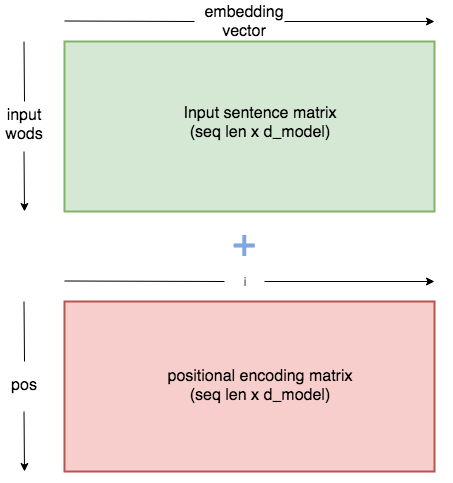

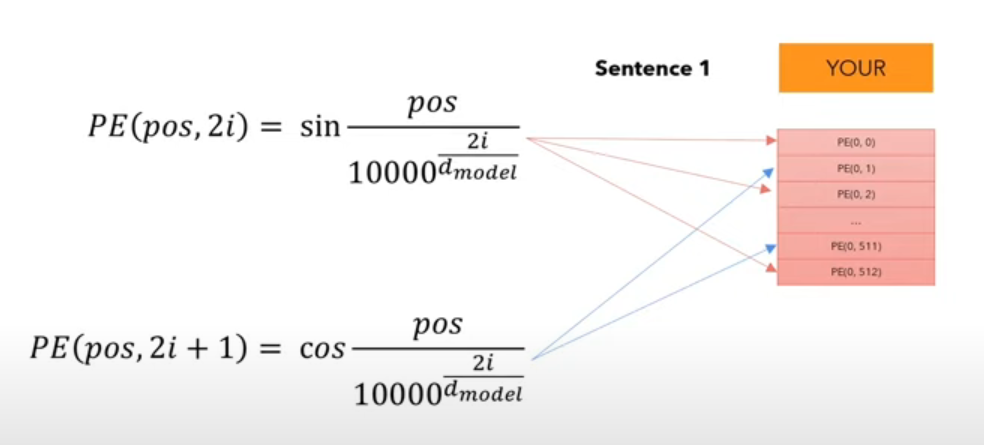

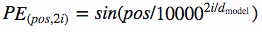



pos -> refers to order in the sentence

i -> refers to position along embedding vector dimension

In [3]:
# we use positional encoding because the attention mechanisms are position invariant
# it gives our model a way to understand where each word or token is in a sequence.

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, sequence_len: int, dropout: float):
        super().__init__()
        self.d_model        = d_model
        self.sequence_len   = sequence_len
        self.dropout        = nn.Dropout(dropout) 
        
        # batch size of 32 
        # seq length of 10 
        # embedding dimension be 512. 
        # Then we will have embedding vector of dimension 32 x 10 x 512
        
        # pe shape(sequence_length x d_model)
        pe = torch.zeros(self.sequence_len, self.d_model)
        
        # NUMERATOR: position vector shape(sequence_len -> sequence_len x 1)
        # For each token(word) in sequence, we will find the embedding vector which is of dimension 1 x 512 
        # and it is added with the correspondng positional vector which is of dimension 1 x 512 
        # to get 1 x 512 dim out for each word/token.
        position = torch.arange(start=0, end=sequence_len, dtype=torch.float).unsqueeze(1)
        
        # Denomenator: div_term of the formula shape(d_model)
        # calculation is done in log space for numerical stability
        div_term = torch.exp(torch.arange(start=0, end=d_model, step=2).float() * (-Math.log(10000.0) / d_model))
        # arange = 2i 
        
        # Apply sine and cosine. The sine is applied to even numbers; cosine to odd numbers
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Add a batch dimension to the positional encoding
        pe = pe.unsqueeze(0) # (1, sequence_len, d_model)
        
        # Tensor that I want to keep in the model
        # Not as a parameter
        # I want it to be saved when I saved the state of the model 
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        # We slice it to match the dimensions of the word embedding
        # We take dim 1 (pos_embeddings) and align them with the dim 1 of x (actual word embeddings)
        # x.shape       = [batch_size=2,sequence_length=5,         embedding_dim=512]
        # self.pe.shape = [             max_sequence_length=1000,  embedding_dim=512]
        # self.pe[:, :x.shape[1]]  # Extracts the first 5 positional encodings
        # take the needed number of sequences instead of all sequences
        x = x + (self.pe[:, :x.shape[1]:]).requires_grad(False)
        return self.dropout(x)


# Layer Normalization
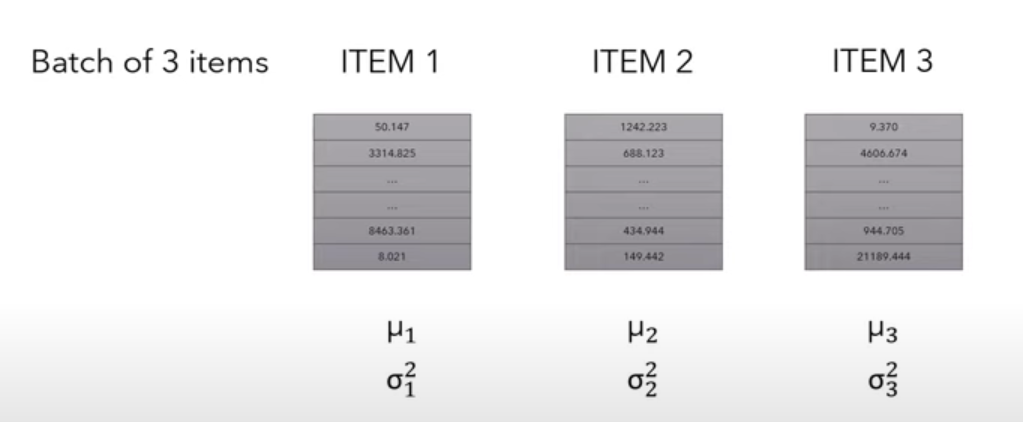

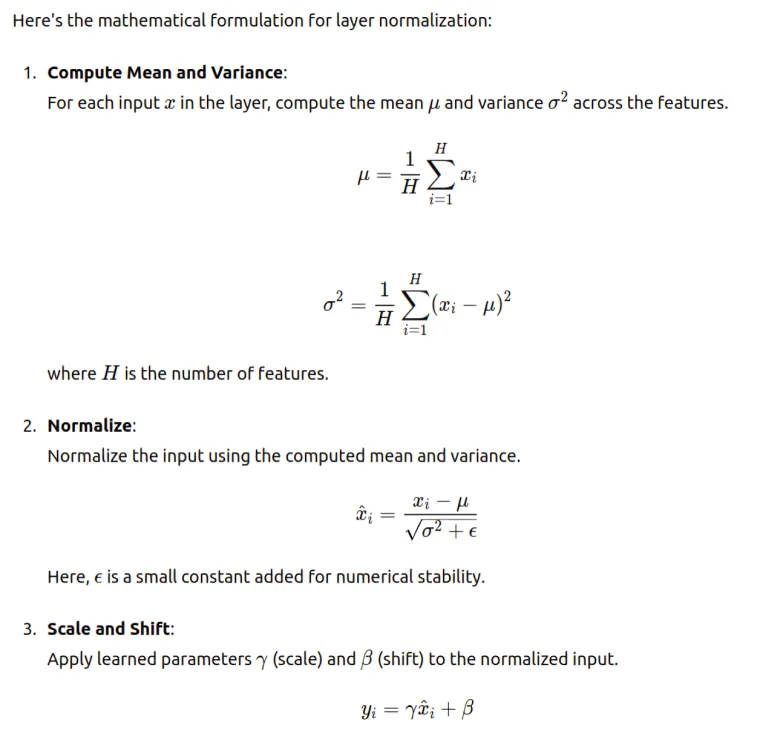

In [5]:
class LayerNormalization(nn.Module):
    
    def __init__(self, features: int = 1, eps: float = 10**-6):
        super().__init__()
        
        # eps in the denominator to avoid dividing by zero if sigma is zero
        self.eps    = eps
        # Gamma (γ): This is a learnable scale parameter. 
        # After normalization, the data is centered around zero with unit variance. 
        # The gamma parameter allows the model to scale the normalized data.
        self.gamma  = nn.Parameter(torch.ones(features)) # Multiplied #(nn.Parameter makes them learnable)
        #Beta (β): This is a learnable shift parameter. 
        # After scaling the data with gamma, the beta parameter allows the model to shift the normalized data.
        self.bias   = nn.Parameter(torch.zeros(features)) # added # (nn.Parameter makes them learnable)
        
    def forward(self,x):
        # x = (batch_size,seq_len ,d_model)
                 # Keep the dimension for broadcasting

        # mean of the last dimension "everything after the batch"
        # keepdim => mean cancels the dimension which is applied to but we want to keep it!
        # dim=-1: This ensures the normalization is done across the feature dimension d_model
        # keepdim=True: Ensures the reduced dimension is retained, 
        # allowing the mean and standard deviation to be broadcast correctly for normalization.
        mean    = x.mean(dim = -1, keepdim=True) # (batch, seq_len, 1)
        std     = x.std(dim = -1, keepdim=True)  # (batch, seq_len, 1)
        
        # Gamma is multiplicative and Beta is additive
        return self.gamma * (x - mean) / (std + self.eps) + self.bias
        